# Linear Discriminant Analysis

## Import thư viện cần thiết

In [1]:
import numpy as np  # Import Numpy as alias np
import pandas as pd  # Import Pandas as alias pd
import matplotlib.pyplot as plt # From Matplotlid import pylot as lias plt
import math # Import Math
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Định nghĩa các đặc trưng của dữ liệu Iris bằng dict features

In [2]:
features = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

## Đọc dữ liệu

Sử dụng Pandas, parse file .data thành csv đưa vào biến dataframe df

In [3]:
df = pd.io.parsers.read_csv(
    filepath_or_buffer='data/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(features.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
X = df[['sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm']].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

## Trực quan hóa dữ liệu

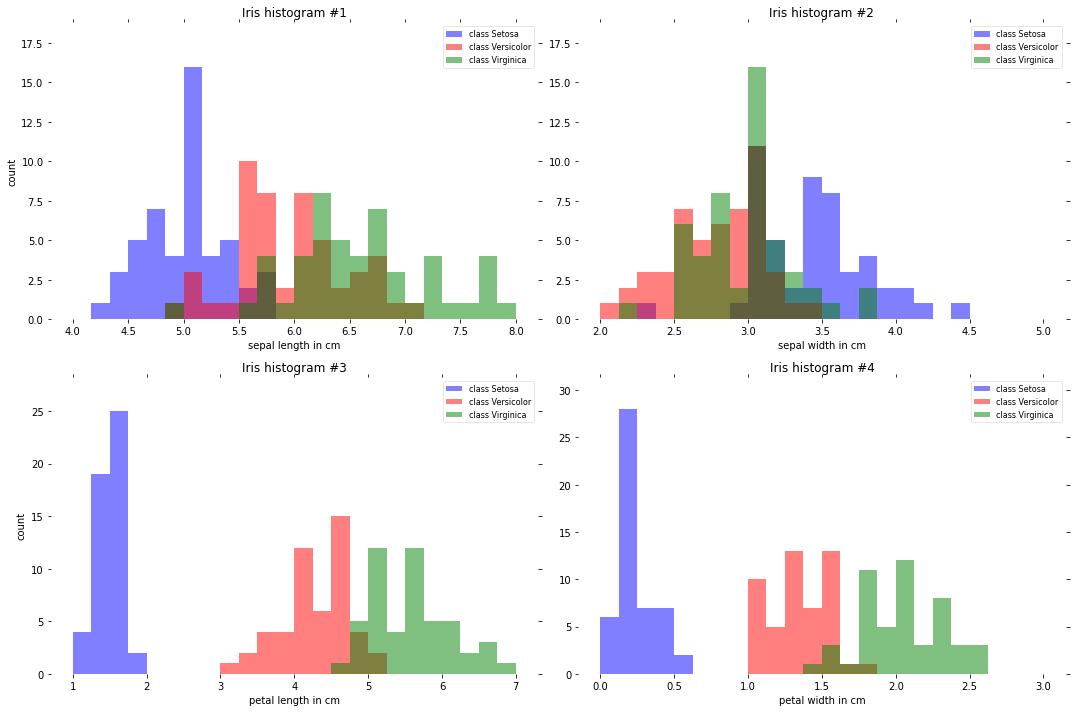

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(features[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       
plt.show()

# Giải thuật Linear Discriminant Analysis

## Bước 01: Tính toán vectơ trung bình d-chiều

In [6]:
# Làm tròn 4 chữ số thập phân
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



## Bước 2: Tính toán ma trận phân tán

### 2.1 Ma trận phân tán trong lớp $S_W$

Ma trận phân tán trong lớp $S_W$ được tính bằng phương trình sau:

$$S_W = \sum_{i=1}^{c}S_i$$

Trong đó:

$S_i = \sum_{x \in D_i}^{n}(x-m_i)(x-m_i)^T$ (ma trận phân tán cho mọi lớp)

$m_i = \frac{1}{n_i}\sum_{x \in D_i}^{n}x_k$ (mean vector)

Ngoài ra, chúng ta cũng có thể tính toán các ma trận hiệp phương sai của lớp bằng cách thêm hệ số tỷ lệ $\frac{1}{N-1}$ vào ma trận phân tán bên trong lớp, để phương trình của chúng ta trở thành:

$$\sum_{i} = \frac{1}{N_{i} - 1}\sum_{x \in D_i}^{n}(x-m_i)(x-m_i)^T$$

$$S_W = \sum_{i=1}^{c}(N_i-1)\sum_i$$

Trong đó:

$N_i$ là kích thước mẫu của lớp tương ứng

Tuy nhiên, các không gian trị riêng kết quả sẽ giống hệt nhau (vector riêng giống hệt nhau, chỉ có các giá trị riêng được chia tỷ lệ khác nhau bởi một hệ số không đổi).

In [7]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # ma trận phân tán cho mọi lớp
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # tạo vectors cột
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # tính tổng ma trận phân tán lớp
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


## 2.2 Ma trận phân tán giữa các lớp $S_B$

Ma trận phân tán giữa các lớp $S_B$ được tính bằng phương trình sau:

$$S_B = \sum_{i=1}^{c}N_i(m_i-m)(m_i-m)^T$$

Trong đó:

$m$ là là trung bình tổng thể, và $m_i$ và $N_i$ lần lượt là trung bình mẫu và kích thước mẫu các lớp tương ứng

In [8]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


## Bước 3: Giải quyết vấn đề giá trị riêng tổng quát cho ma trận $S_W^{-1}S_B$

In [9]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.2122]
 [-0.2111]
 [-0.2751]
 [ 0.767 ]]
Eigenvalue 3: 3.31e-15

Eigenvector 4: 
[[-0.2122]
 [-0.2111]
 [-0.2751]
 [ 0.767 ]]
Eigenvalue 4: 3.31e-15


Kiểm tra tính toán vector riêng-giá trị riêng

Kiểm tra nhanh xem phép tính vector riêng-giá trị riêng là đúng và thỏa mãn phương trình

$$A\nu = \lambda \nu$$

Trong đó: 

$A = S_W^{-1}S_B$

$\nu$ là vector riêng

$\lambda$ là giá trị riêng

In [10]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


## Step 4: Chọn phân biệt tuyến tính cho không gian đặc trưng con mới

### Step 4.1 Sắp xếp các giá trị riêng theo chiều giảm dần các giá trị riêng

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.2719577997298
0.27756686384004753
6.935906860079298e-15
6.935906860079298e-15


Có thể thấy rằng 2 giá trị riêng gần bằng 0, để tránh việc nhận định sai lý do nó gần bằng không (do tính toán dấu chấm động). Kiểm tra bằng việc tính bằng phần trăm

In [12]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


Cặp giá trị riên đầu tiên cho thấy là cái có nhiều thông tin nhất và chúng ta sẽ không mất nhiều thông tin nếu chúng tôi hình thành một đặc trưng 1D được phân cách dựa trên cặp giá trị riêng này.

### 4.2. Chọn k vector riêng có giá trị riêng lớn nhất
Sau khi sắp xếp các cặp vector riêng - giá trị riêng theo chiều giảm dần giá trị riêng. Xây dựng ma trận $k \times d-dimensional$ vector riêng $W$ ($4 \times 2$: dựa trên 2 cặp giá trị riêng nhiều thông tin nhất) và do đó giảm không gian đặc trưng 4 chiều ban đầu thành không gian con đặc trưng 2 chiều.)

In [13]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


# Bước 5: Chuyển đổi các mẫu sang không gian con mới
Sử dụng ma trận $4 \times 2$ chiều $W$ đã tính được ở bước 4 để chuyển đổi mẫu sang không gian con mới bằng phương trình 

$$Y = X \times W$$

Trong đó:

$X$ là ma trận $n \times d$ chiều biểu diễn $n$ mẫu

$Y$ là ma trận $n \times k$ chiều, biểu diễn cho mẫu đã chuyển đổi sang không gian con mới.

In [14]:
## Step 5: Transforming the samples onto the new subspace
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

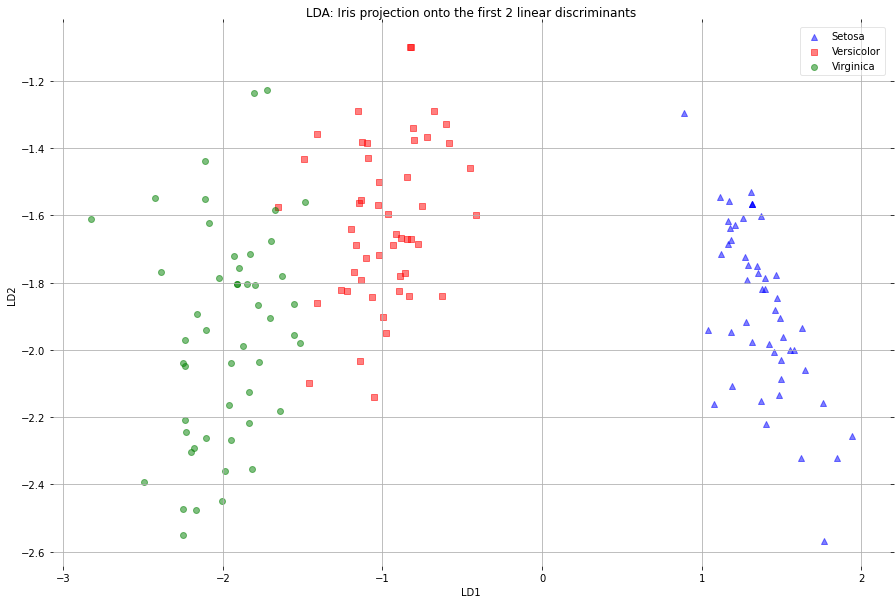

In [15]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()
plt.figure(figsize=(15,10))
plot_step_lda()

# So sánh PCA và LDA

![](./images/lda_1.png)

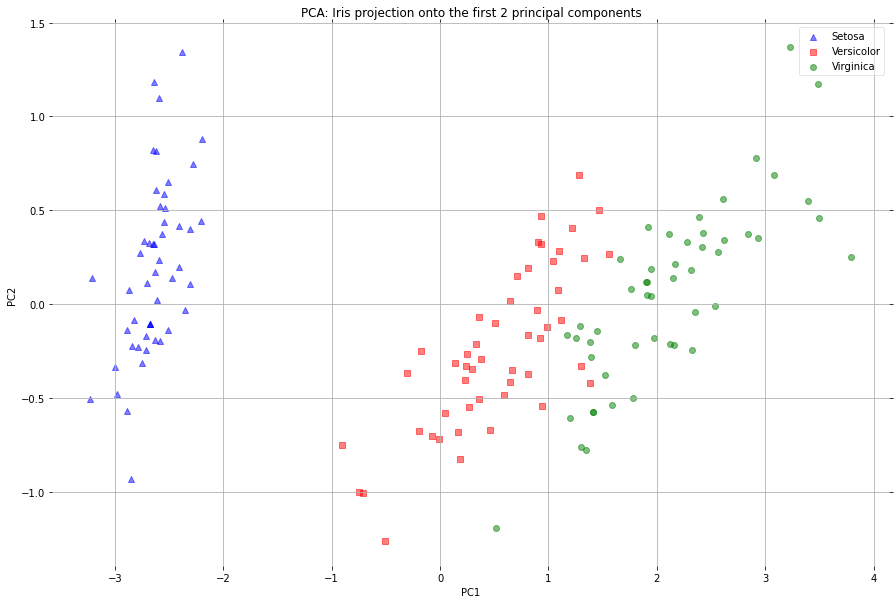

In [16]:
sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()
plt.figure(figsize=(15,10))
plot_pca()

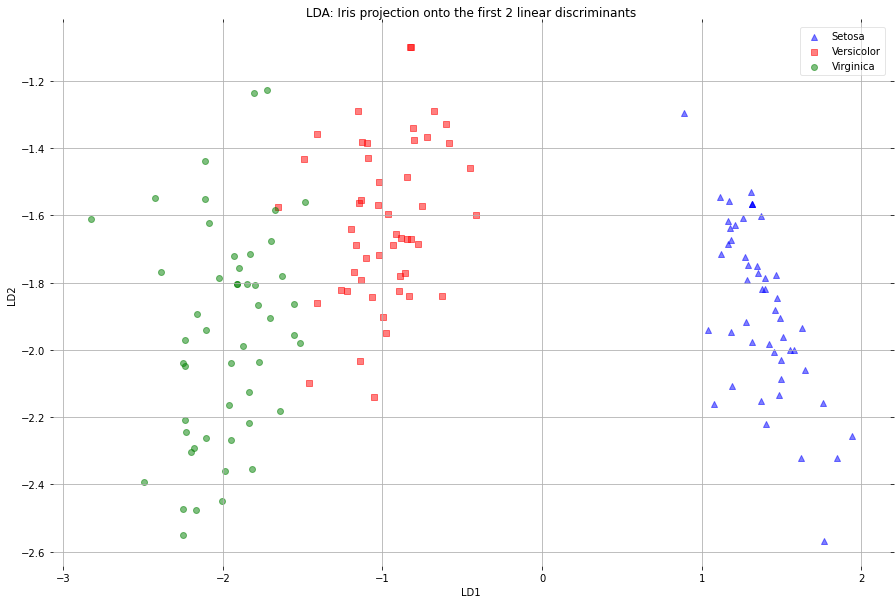

In [17]:
plt.figure(figsize=(15,10))
plot_step_lda()